### Training of modified U-Net for Optic Disc on DRISHTI-GS database (cross-validation fold #0).

512 px cropped by Optic Disc area and resized to 128 px images were used.

You can either train your model or upload a pre-trained one from:
*../models_weights/02.03,13:57,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5*

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import glob
from datetime import datetime
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage
import skimage.exposure
import skimage.transform
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from dual_IDG import DualImageDataGenerator

In [4]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, \
    Lambda, UpSampling2D, Cropping2D, Concatenate
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [5]:
print('Keras version:', keras.__version__)
print('TensorFlow version:', tf.__version__)

Keras version: 2.3.1
TensorFlow version: 1.14.0


In [6]:
K.set_image_data_format('channels_first')

In [7]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""

    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))

def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [8]:
def dice(y_true, y_pred):

    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)

def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)

def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))

def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

In [9]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)

def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)


In [10]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS.hdf5'), 'r')

In [11]:
def get_unet_light(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv5)

    up6 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv6)

    up7 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv7)

    up8 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv8)

    up9 = Concatenate(axis=1)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(input=inputs, output=conv10)

    return model

In [12]:
model = get_unet_light(img_rows=128, img_cols=128)
model.compile(optimizer=SGD(lr=1e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 128, 128)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 128, 128) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 128, 128) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 128, 128) 9248        dropout_1[0][0]                  
____________________________________________________________________________________________

#### DRISHTI-GS

Accessing data, preparing train/validation sets division:

In [15]:
img_train = h5f['DRISHTI-GS/512 px/img_cropped']
cup_train = h5f['DRISHTI-GS/512 px/cup_cropped']
disc_train = h5f['DRISHTI-GS/512 px/disc_cropped']
disc_locations = h5f['DRISHTI-GS/512 px/disc_locations']

KeyError: 'Unable to open object (component not found)'

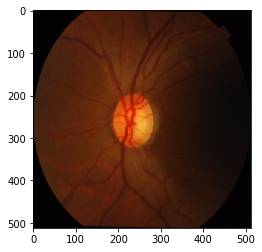

(50, 512, 512, 3)


In [14]:
plt.imshow(img_train[40])
plt.show()
print(img_train.shape)

In [15]:
img_train, cup_train, disc_train, disc_locations

(<HDF5 dataset "images": shape (50, 512, 512, 3), type "|u1">,
 <HDF5 dataset "cup": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc": shape (50, 512, 512, 1), type "|u1">,
 <HDF5 dataset "disc_locations": shape (50, 4), type "<i8">)

In [16]:
train_idx = np.arange(0, 49)
test_idx  = np.arange(0, 50)

#### Generator of augmented data:

In [17]:
train_idg = DualImageDataGenerator(horizontal_flip=True, vertical_flip=True,
                                   rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                   zoom_range=(0.8, 1.2),
                                   fill_mode='constant', cval=0.0)
test_idg = DualImageDataGenerator()

#### Preprocessing function and data generator:

In [18]:
def preprocess(batch_X, batch_y, train_or_test='train'):
    batch_X = batch_X / 255.0
    # the following line thresholds segmentation mask for DRISHTI-GS, since it contains averaged soft maps:
    batch_y = batch_y >= 0.5
    
    if train_or_test == 'train':
        batch_X, batch_y = next(train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    elif train_or_test == 'test':
        batch_X, batch_y = next(test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    batch_X = th_to_tf_encoding(batch_X)
    batch_X = [skimage.exposure.equalize_adapthist(batch_X[i])
               for i in range(len(batch_X))]
    batch_X = np.array(batch_X)
    batch_X = tf_to_th_encoding(batch_X)
    return batch_X, batch_y


def data_generator(X, y, resize_to=128, train_or_test='train', batch_size=3, return_orig=False, stationary=False):
    """Gets random batch of data, 
    divides by 255,
    feeds it to DualImageDataGenerator."""
      
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)

        batch_X = [X[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
                   for i in idx]
        batch_X = [np.rollaxis(img, 2) for img in batch_X]

        batch_X = [skimage.transform.resize(np.rollaxis(img, 0, 3), (resize_to, resize_to))
                   for img in batch_X]
        batch_X = np.array(batch_X).copy()
        
        batch_y = [y[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
                   for i in idx]
        batch_y = [img[..., 0] for img in batch_y]
        batch_y = [skimage.transform.resize(img, (resize_to, resize_to))[..., None] for img in batch_y]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X)
        batch_y = tf_to_th_encoding(batch_y)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()
        
        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)
                
        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

Testing the data generator and generator for augmented data:

In [19]:
gen = data_generator(img_train, cup_train, 128, 'train', batch_size=1)
batch = next(gen)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [20]:
arch_name = "OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 0, SGD, log_dice loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{}'.format(arch_name))

In [21]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

In [22]:
img_test = h5f['DRISHTI-GS-test/512 px/images']
cup_test = h5f['DRISHTI-GS-test/512 px/cup']
disc_test = h5f['DRISHTI-GS-test/512 px/disc']
disc_locations_test = h5f['DRISHTI-GS-test/512 px/disc_locations']

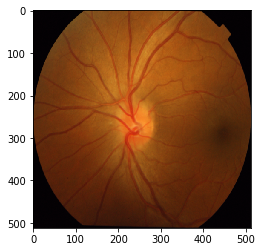

51


In [40]:
plt.imshow(img_test[50])
plt.show()
print(len(img_test))

In [24]:
X_valid, Y_valid = next(data_generator(img_test, cup_test, train_or_test='test', batch_size=100, stationary=True))

### Training

If a pretrained model needs to be used, first run "Loading model" section below and then go the "Comprehensive visual check", skipping this section.

In [28]:
history = model.fit_generator(data_generator(img_train, cup_train, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,                    
                              validation_data=(X_valid, Y_valid),                              
                              epochs=500, verbose=1,                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log_cup_color.csv')),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               'last_checkpoint_cup_color.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

Epoch 1/500
99/99 [==============================] - 34s 346ms/step - loss: 1.8888 - mean_IOU_gpu: 3.4565e-04 - dice_metric: 6.8927e-04 - val_loss: 1.7736 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 2/500
99/99 [==============================] - 37s 371ms/step - loss: 1.7908 - mean_IOU_gpu: 0.0000e+00 - dice_metric: 0.0000e+00 - val_loss: 1.6378 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 3/500
99/99 [==============================] - 37s 374ms/step - loss: 1.6055 - mean_IOU_gpu: 0.0000e+00 - dice_metric: 0.0000e+00 - val_loss: 1.3434 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 4/500
99/99 [==============================] - 37s 374ms/step - loss: 1.2324 - mean_IOU_gpu: 2.6782e-04 - dice_metric: 5.2927e-04 - val_loss: 0.8543 - val_mean_IOU_gpu: 0.0000e+00 - val_dice_metric: 0.0000e+00
Epoch 5/500
99/99 [==============================] - 37s 378ms/step - loss: 0.6472 - mean_IOU_gpu: 0.2303 - dice_metric: 0.3279 - val_lo

Epoch 82/500
99/99 [==============================] - 36s 364ms/step - loss: 0.1678 - mean_IOU_gpu: 0.7091 - dice_metric: 0.8200 - val_loss: 0.6696 - val_mean_IOU_gpu: 0.3924 - val_dice_metric: 0.5123
Epoch 83/500
99/99 [==============================] - 36s 363ms/step - loss: 0.1446 - mean_IOU_gpu: 0.7296 - dice_metric: 0.8377 - val_loss: 0.5717 - val_mean_IOU_gpu: 0.4438 - val_dice_metric: 0.5677
Epoch 84/500
99/99 [==============================] - 36s 367ms/step - loss: 0.1591 - mean_IOU_gpu: 0.7122 - dice_metric: 0.8247 - val_loss: 0.8588 - val_mean_IOU_gpu: 0.3154 - val_dice_metric: 0.4243
Epoch 85/500
99/99 [==============================] - 37s 371ms/step - loss: 0.1280 - mean_IOU_gpu: 0.7563 - dice_metric: 0.8556 - val_loss: 0.9519 - val_mean_IOU_gpu: 0.2941 - val_dice_metric: 0.4000
Epoch 86/500
99/99 [==============================] - 36s 363ms/step - loss: 0.1661 - mean_IOU_gpu: 0.7034 - dice_metric: 0.8173 - val_loss: 0.6020 - val_mean_IOU_gpu: 0.4449 - val_dice_metric: 0.

Epoch 123/500
99/99 [==============================] - 36s 363ms/step - loss: 0.1197 - mean_IOU_gpu: 0.7601 - dice_metric: 0.8601 - val_loss: 0.2644 - val_mean_IOU_gpu: 0.6484 - val_dice_metric: 0.7588
Epoch 124/500
99/99 [==============================] - 36s 364ms/step - loss: 0.1439 - mean_IOU_gpu: 0.7384 - dice_metric: 0.8418 - val_loss: 0.2115 - val_mean_IOU_gpu: 0.6870 - val_dice_metric: 0.7948
Epoch 125/500
99/99 [==============================] - 36s 365ms/step - loss: 0.1539 - mean_IOU_gpu: 0.7235 - dice_metric: 0.8309 - val_loss: 0.3188 - val_mean_IOU_gpu: 0.5949 - val_dice_metric: 0.7151
Epoch 126/500
99/99 [==============================] - 36s 364ms/step - loss: 0.1316 - mean_IOU_gpu: 0.7543 - dice_metric: 0.8532 - val_loss: 1.2610 - val_mean_IOU_gpu: 0.2059 - val_dice_metric: 0.2887
Epoch 127/500
99/99 [==============================] - 36s 364ms/step - loss: 0.1582 - mean_IOU_gpu: 0.7140 - dice_metric: 0.8257 - val_loss: 0.5694 - val_mean_IOU_gpu: 0.4684 - val_dice_metri

Epoch 204/500
99/99 [==============================] - 36s 366ms/step - loss: 0.1402 - mean_IOU_gpu: 0.7415 - dice_metric: 0.8437 - val_loss: 0.3866 - val_mean_IOU_gpu: 0.5630 - val_dice_metric: 0.6831
Epoch 205/500
99/99 [==============================] - 36s 364ms/step - loss: 0.1318 - mean_IOU_gpu: 0.7440 - dice_metric: 0.8479 - val_loss: 0.3137 - val_mean_IOU_gpu: 0.5898 - val_dice_metric: 0.7095
Epoch 206/500
99/99 [==============================] - 36s 363ms/step - loss: 0.1139 - mean_IOU_gpu: 0.7721 - dice_metric: 0.8669 - val_loss: 0.2379 - val_mean_IOU_gpu: 0.6491 - val_dice_metric: 0.7675
Epoch 207/500
99/99 [==============================] - 36s 364ms/step - loss: 0.1102 - mean_IOU_gpu: 0.7796 - dice_metric: 0.8718 - val_loss: 0.2496 - val_mean_IOU_gpu: 0.6467 - val_dice_metric: 0.7624
Epoch 208/500
99/99 [==============================] - 36s 365ms/step - loss: 0.1055 - mean_IOU_gpu: 0.7793 - dice_metric: 0.8731 - val_loss: 0.3043 - val_mean_IOU_gpu: 0.6299 - val_dice_metri

Epoch 285/500
99/99 [==============================] - 36s 363ms/step - loss: 0.0974 - mean_IOU_gpu: 0.7954 - dice_metric: 0.8828 - val_loss: 0.2073 - val_mean_IOU_gpu: 0.6837 - val_dice_metric: 0.7963
Epoch 286/500
99/99 [==============================] - 36s 361ms/step - loss: 0.0894 - mean_IOU_gpu: 0.8069 - dice_metric: 0.8910 - val_loss: 0.1595 - val_mean_IOU_gpu: 0.7303 - val_dice_metric: 0.8317
Epoch 287/500
99/99 [==============================] - 36s 362ms/step - loss: 0.0991 - mean_IOU_gpu: 0.7912 - dice_metric: 0.8807 - val_loss: 0.2948 - val_mean_IOU_gpu: 0.6226 - val_dice_metric: 0.7400
Epoch 288/500
99/99 [==============================] - 36s 363ms/step - loss: 0.1096 - mean_IOU_gpu: 0.7792 - dice_metric: 0.8712 - val_loss: 0.1652 - val_mean_IOU_gpu: 0.7201 - val_dice_metric: 0.8247
Epoch 289/500
99/99 [==============================] - 36s 362ms/step - loss: 0.1198 - mean_IOU_gpu: 0.7664 - dice_metric: 0.8616 - val_loss: 0.1950 - val_mean_IOU_gpu: 0.6901 - val_dice_metri

Epoch 366/500
99/99 [==============================] - 37s 371ms/step - loss: 0.1087 - mean_IOU_gpu: 0.7834 - dice_metric: 0.8731 - val_loss: 0.1474 - val_mean_IOU_gpu: 0.7447 - val_dice_metric: 0.8423
Epoch 367/500
99/99 [==============================] - 36s 363ms/step - loss: 0.0980 - mean_IOU_gpu: 0.7972 - dice_metric: 0.8835 - val_loss: 0.1763 - val_mean_IOU_gpu: 0.7321 - val_dice_metric: 0.8307
Epoch 368/500
99/99 [==============================] - 36s 364ms/step - loss: 0.1065 - mean_IOU_gpu: 0.7826 - dice_metric: 0.8740 - val_loss: 0.2016 - val_mean_IOU_gpu: 0.7029 - val_dice_metric: 0.8096
Epoch 369/500
99/99 [==============================] - 36s 367ms/step - loss: 0.0975 - mean_IOU_gpu: 0.7980 - dice_metric: 0.8846 - val_loss: 0.1516 - val_mean_IOU_gpu: 0.7423 - val_dice_metric: 0.8397
Epoch 370/500
99/99 [==============================] - 39s 395ms/step - loss: 0.0906 - mean_IOU_gpu: 0.8085 - dice_metric: 0.8909 - val_loss: 0.1412 - val_mean_IOU_gpu: 0.7488 - val_dice_metri

Epoch 447/500
99/99 [==============================] - 36s 363ms/step - loss: 0.0880 - mean_IOU_gpu: 0.8099 - dice_metric: 0.8923 - val_loss: 0.1642 - val_mean_IOU_gpu: 0.7394 - val_dice_metric: 0.8364
Epoch 448/500
99/99 [==============================] - 36s 364ms/step - loss: 0.0864 - mean_IOU_gpu: 0.8117 - dice_metric: 0.8937 - val_loss: 0.1347 - val_mean_IOU_gpu: 0.7594 - val_dice_metric: 0.8535
Epoch 449/500
99/99 [==============================] - 36s 363ms/step - loss: 0.0781 - mean_IOU_gpu: 0.8257 - dice_metric: 0.9032 - val_loss: 0.1493 - val_mean_IOU_gpu: 0.7467 - val_dice_metric: 0.8421
Epoch 450/500
99/99 [==============================] - 36s 364ms/step - loss: 0.0897 - mean_IOU_gpu: 0.8074 - dice_metric: 0.8909 - val_loss: 0.1392 - val_mean_IOU_gpu: 0.7554 - val_dice_metric: 0.8501
Epoch 451/500
99/99 [==============================] - 36s 364ms/step - loss: 0.0892 - mean_IOU_gpu: 0.8060 - dice_metric: 0.8904 - val_loss: 0.1369 - val_mean_IOU_gpu: 0.7576 - val_dice_metri

### Visual check

image #0


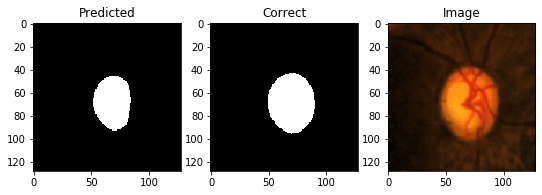

IOU: 0.7280966639518738
Dice: 0.8426573426573427
image #1


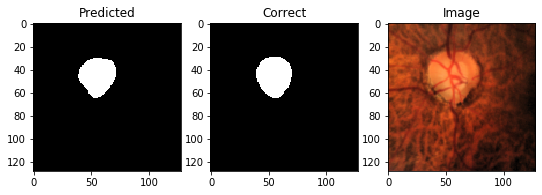

IOU: 0.901583731174469
Dice: 0.9482450922070196
image #2


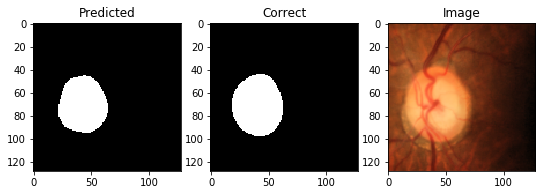

IOU: 0.854669451713562
Dice: 0.9216407355021217
image #3


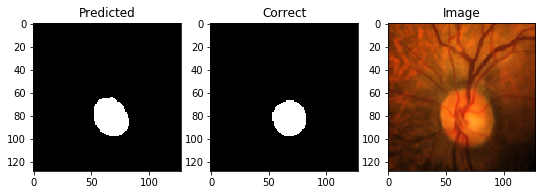

IOU: 0.8552147150039673
Dice: 0.921957671957672
image #4


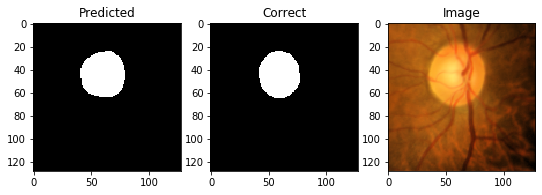

IOU: 0.8793774247169495
Dice: 0.9358178053830227
image #5


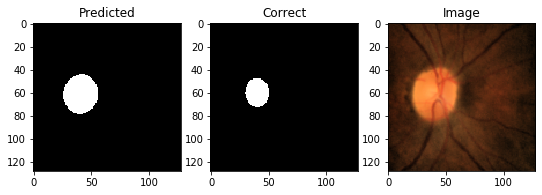

IOU: 0.5012376308441162
Dice: 0.6677658697444353
image #6


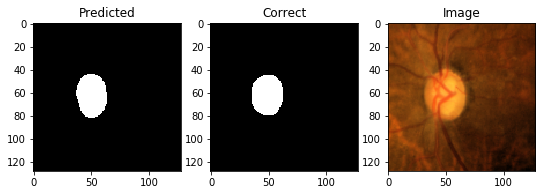

IOU: 0.859649121761322
Dice: 0.9245283018867925
image #7


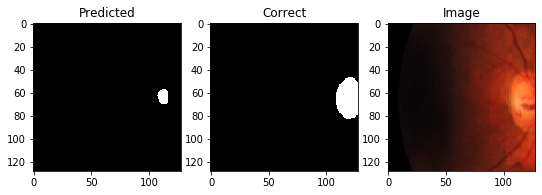

IOU: 0.16027875244617462
Dice: 0.27627627627627627
image #8


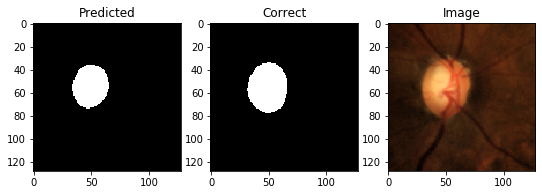

IOU: 0.7804054021835327
Dice: 0.8766603415559773
image #9


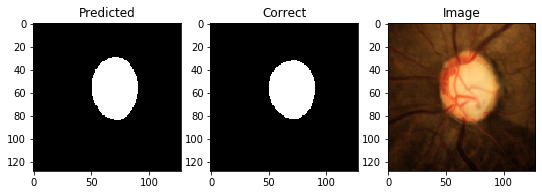

IOU: 0.9317784309387207
Dice: 0.9646845759130698
image #10


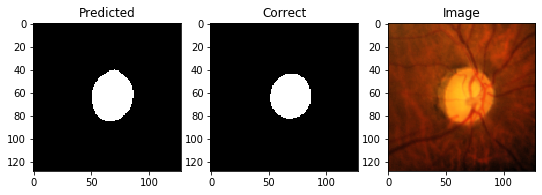

IOU: 0.8634538054466248
Dice: 0.9267241379310345
image #11


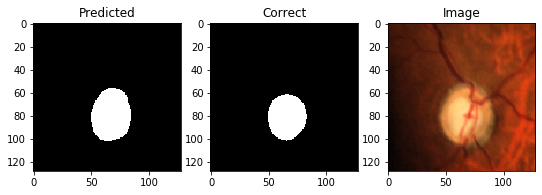

IOU: 0.824823260307312
Dice: 0.9040034438226431
image #12


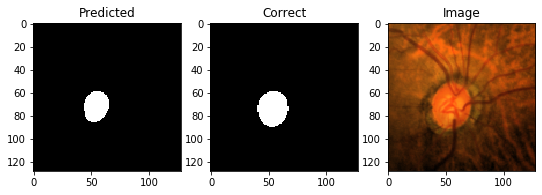

IOU: 0.7138461470603943
Dice: 0.8330341113105925
image #13


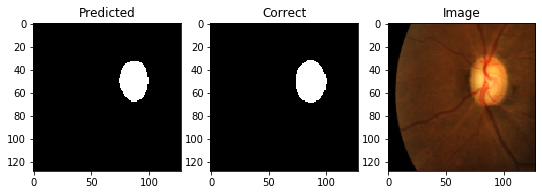

IOU: 0.8916128873825073
Dice: 0.9427012278308322
image #14


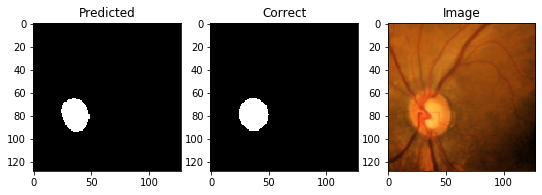

IOU: 0.8624787926673889
Dice: 0.92616226071103
image #15


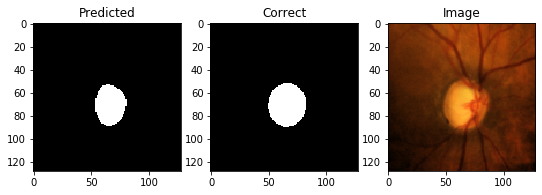

IOU: 0.7676560878753662
Dice: 0.8685581933989577
image #16


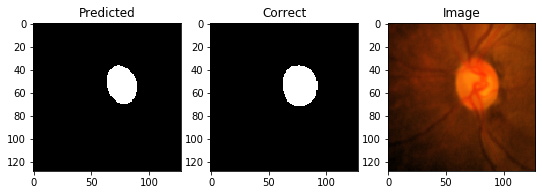

IOU: 0.7830626368522644
Dice: 0.878334417696812
image #17


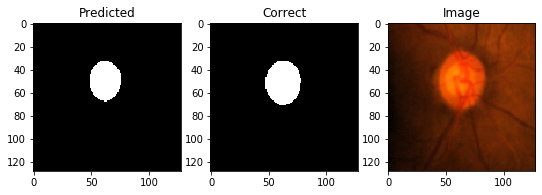

IOU: 0.801948070526123
Dice: 0.8900900900900901
image #18


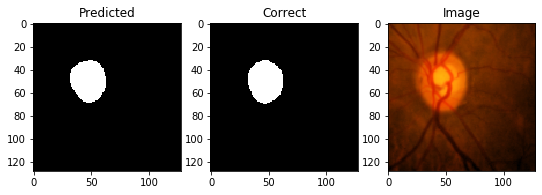

IOU: 0.9322404265403748
Dice: 0.9649321266968326
image #19


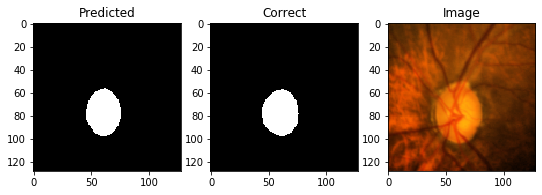

IOU: 0.9314796328544617
Dice: 0.9645244215938303
image #20


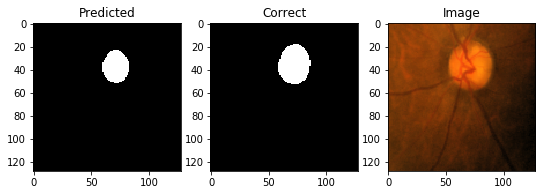

IOU: 0.6794195175170898
Dice: 0.8091123330714847
image #21


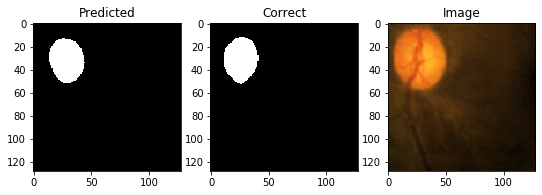

IOU: 0.79682856798172
Dice: 0.8869277440706013
image #22


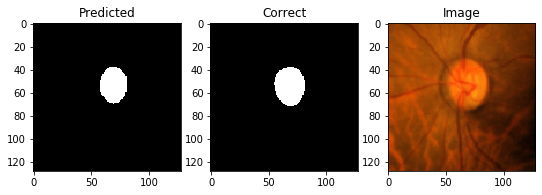

IOU: 0.8202247023582458
Dice: 0.9012345679012346
image #23


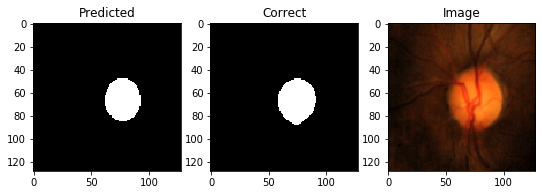

IOU: 0.8130930066108704
Dice: 0.8969126111983254
image #24


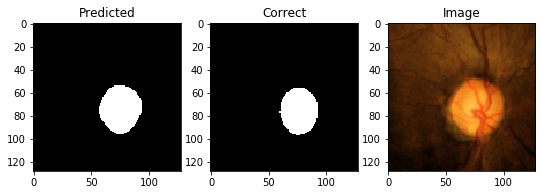

IOU: 0.8304668068885803
Dice: 0.9073825503355705
image #25


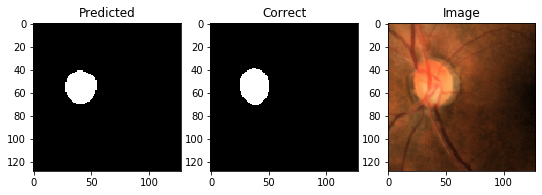

IOU: 0.744413435459137
Dice: 0.8534827862289832
image #26


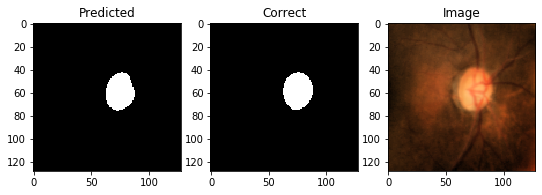

IOU: 0.9056047201156616
Dice: 0.9504643962848297
image #27


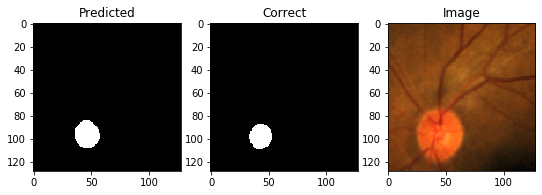

IOU: 0.6644444465637207
Dice: 0.7983978638184246
image #28


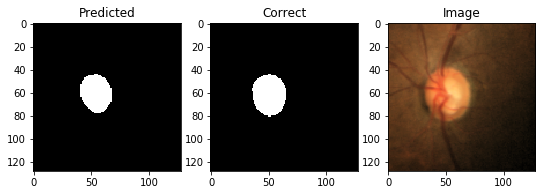

IOU: 0.7185430526733398
Dice: 0.8362235067437379
image #29


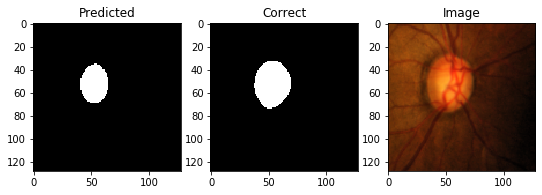

IOU: 0.642642617225647
Dice: 0.7824497257769653
image #30


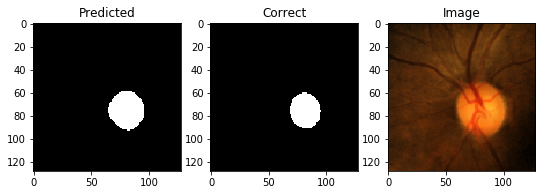

IOU: 0.8029925227165222
Dice: 0.8907330567081605
image #31


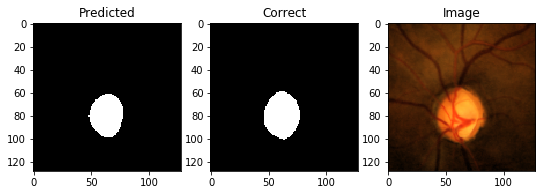

IOU: 0.8469284772872925
Dice: 0.9171210468920392
image #32


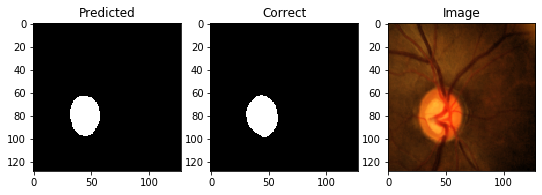

IOU: 0.9139504432678223
Dice: 0.9550408719346049
image #33


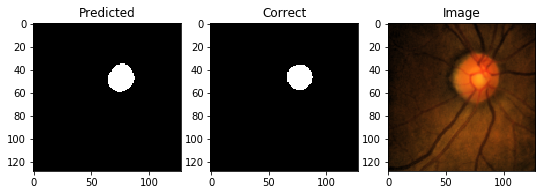

IOU: 0.8280543088912964
Dice: 0.905940594059406
image #34


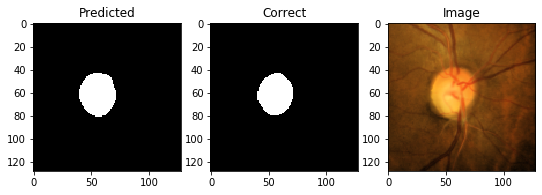

IOU: 0.9048117399215698
Dice: 0.9500274574409665
image #35


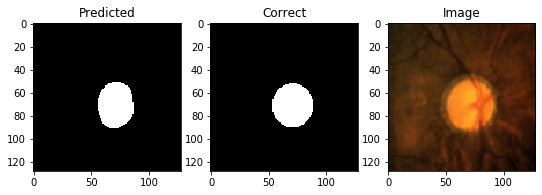

IOU: 0.8774954676628113
Dice: 0.9347510874818753
image #36


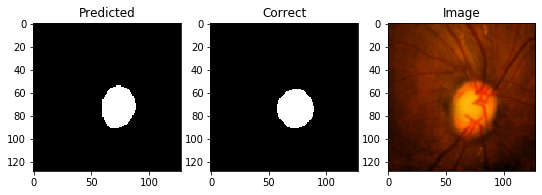

IOU: 0.8538206219673157
Dice: 0.921146953405018
image #37


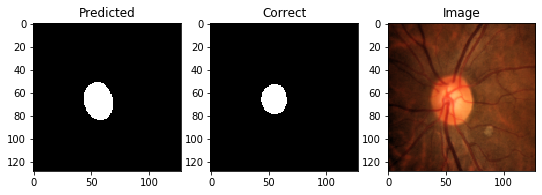

IOU: 0.7048929929733276
Dice: 0.8269058295964126
image #38


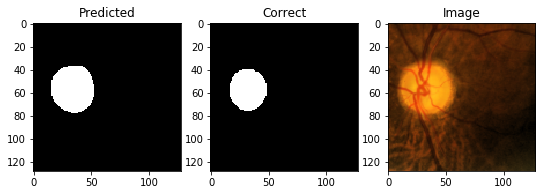

IOU: 0.7485806941986084
Dice: 0.8562152133580705
image #39


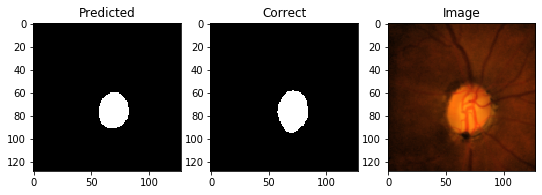

IOU: 0.7643312215805054
Dice: 0.8664259927797834
image #40


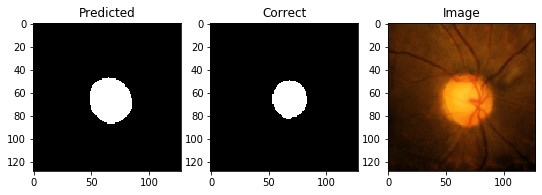

IOU: 0.6744995713233948
Dice: 0.8056133056133056
image #41


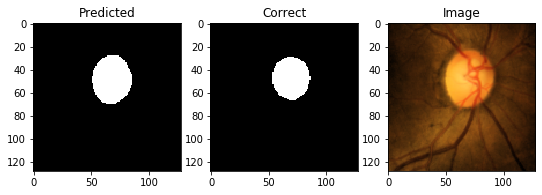

IOU: 0.8072289228439331
Dice: 0.8933333333333333
image #42


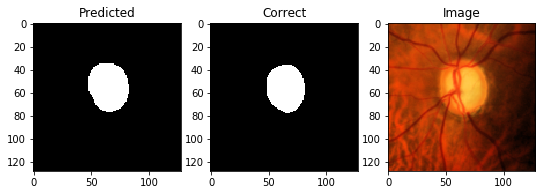

IOU: 0.9021739363670349
Dice: 0.9485714285714286
image #43


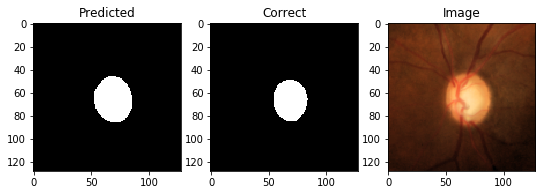

IOU: 0.8045976758003235
Dice: 0.89171974522293
image #44


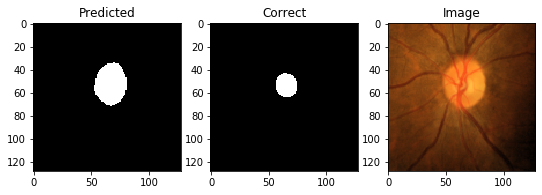

IOU: 0.388958603143692
Dice: 0.5600722673893406
image #45


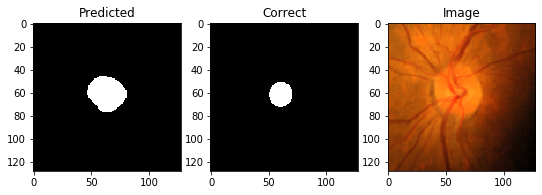

IOU: 0.44573643803596497
Dice: 0.6166219839142091
image #46


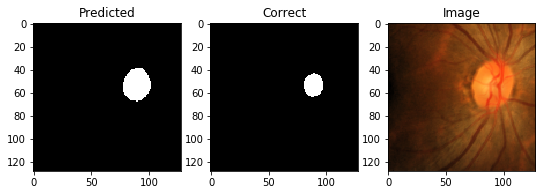

IOU: 0.51031893491745
Dice: 0.675776397515528
image #47


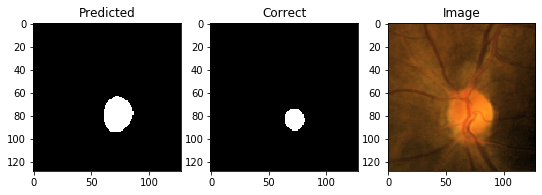

IOU: 0.4178861677646637
Dice: 0.5894495412844036
image #48


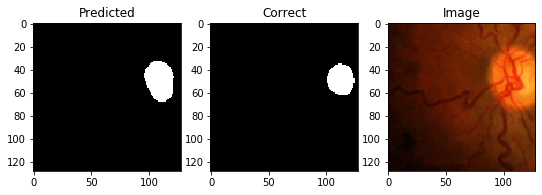

IOU: 0.5885486006736755
Dice: 0.740989103101425
image #49


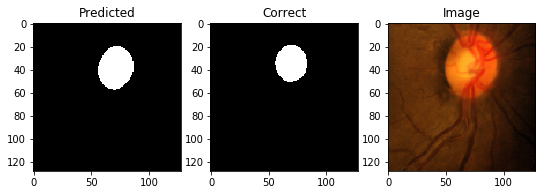

IOU: 0.687299907207489
Dice: 0.814674256799494


In [29]:
pred_iou, pred_dice = [], []
pred_cup = []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = img_test[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    pred_cup.append(pred)
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
        
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

Acquiring scores for the validation set:

In [30]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.7582736
0.8512603199199655


### Loading model

In [33]:
X_valid, Z_valid = next(data_generator(img_test, disc_test, train_or_test='test', batch_size=100, stationary=True))

In [34]:
history = model.fit_generator(data_generator(img_train, disc_train, train_or_test='train', batch_size=1), 
                              steps_per_epoch=99,
                              max_queue_size=1,                    
                              validation_data=(X_valid, Z_valid),                              
                              epochs=500, verbose=1,                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log_disc_color.csv')),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               'last_checkpoint_disc_color.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

Epoch 1/500
99/99 [==============================] - 43s 439ms/step - loss: 0.1378 - mean_IOU_gpu: 0.7575 - dice_metric: 0.8531 - val_loss: 0.0934 - val_mean_IOU_gpu: 0.8105 - val_dice_metric: 0.8919
Epoch 2/500
99/99 [==============================] - 43s 432ms/step - loss: 0.0754 - mean_IOU_gpu: 0.8352 - dice_metric: 0.9089 - val_loss: 0.1050 - val_mean_IOU_gpu: 0.7952 - val_dice_metric: 0.8821
Epoch 3/500
99/99 [==============================] - 43s 437ms/step - loss: 0.0706 - mean_IOU_gpu: 0.8441 - dice_metric: 0.9142 - val_loss: 0.0816 - val_mean_IOU_gpu: 0.8301 - val_dice_metric: 0.9039
Epoch 4/500
99/99 [==============================] - 43s 433ms/step - loss: 0.0583 - mean_IOU_gpu: 0.8658 - dice_metric: 0.9274 - val_loss: 0.0912 - val_mean_IOU_gpu: 0.8154 - val_dice_metric: 0.8951
Epoch 5/500
99/99 [==============================] - 37s 372ms/step - loss: 0.0552 - mean_IOU_gpu: 0.8726 - dice_metric: 0.9312 - val_loss: 0.0991 - val_mean_IOU_gpu: 0.8041 - val_dice_metric: 0.8880


Epoch 42/500
99/99 [==============================] - 47s 475ms/step - loss: 0.0401 - mean_IOU_gpu: 0.9025 - dice_metric: 0.9484 - val_loss: 0.0721 - val_mean_IOU_gpu: 0.8479 - val_dice_metric: 0.9150
Epoch 43/500
99/99 [==============================] - 47s 472ms/step - loss: 0.0383 - mean_IOU_gpu: 0.9061 - dice_metric: 0.9505 - val_loss: 0.0719 - val_mean_IOU_gpu: 0.8487 - val_dice_metric: 0.9153
Epoch 44/500
99/99 [==============================] - 47s 470ms/step - loss: 0.0413 - mean_IOU_gpu: 0.9013 - dice_metric: 0.9477 - val_loss: 0.0779 - val_mean_IOU_gpu: 0.8403 - val_dice_metric: 0.9095
Epoch 45/500
99/99 [==============================] - 47s 474ms/step - loss: 0.0408 - mean_IOU_gpu: 0.9002 - dice_metric: 0.9471 - val_loss: 0.0889 - val_mean_IOU_gpu: 0.8235 - val_dice_metric: 0.8991
Epoch 46/500
99/99 [==============================] - 47s 474ms/step - loss: 0.0398 - mean_IOU_gpu: 0.9037 - dice_metric: 0.9491 - val_loss: 0.0830 - val_mean_IOU_gpu: 0.8321 - val_dice_metric: 0.

Epoch 83/500
99/99 [==============================] - 55s 557ms/step - loss: 0.0353 - mean_IOU_gpu: 0.9121 - dice_metric: 0.9538 - val_loss: 0.0924 - val_mean_IOU_gpu: 0.8219 - val_dice_metric: 0.8974
Epoch 84/500
99/99 [==============================] - 54s 542ms/step - loss: 0.0378 - mean_IOU_gpu: 0.9066 - dice_metric: 0.9508 - val_loss: 0.0771 - val_mean_IOU_gpu: 0.8443 - val_dice_metric: 0.9118
Epoch 85/500
99/99 [==============================] - 54s 541ms/step - loss: 0.0356 - mean_IOU_gpu: 0.9116 - dice_metric: 0.9536 - val_loss: 0.0740 - val_mean_IOU_gpu: 0.8500 - val_dice_metric: 0.9149
Epoch 86/500
99/99 [==============================] - 55s 555ms/step - loss: 0.0370 - mean_IOU_gpu: 0.9088 - dice_metric: 0.9520 - val_loss: 0.0735 - val_mean_IOU_gpu: 0.8487 - val_dice_metric: 0.9148
Epoch 87/500
99/99 [==============================] - 55s 555ms/step - loss: 0.0355 - mean_IOU_gpu: 0.9116 - dice_metric: 0.9535 - val_loss: 0.0800 - val_mean_IOU_gpu: 0.8386 - val_dice_metric: 0.

Epoch 124/500
99/99 [==============================] - 55s 552ms/step - loss: 0.0352 - mean_IOU_gpu: 0.9136 - dice_metric: 0.9546 - val_loss: 0.0681 - val_mean_IOU_gpu: 0.8616 - val_dice_metric: 0.9220
Epoch 125/500
99/99 [==============================] - 55s 558ms/step - loss: 0.0341 - mean_IOU_gpu: 0.9144 - dice_metric: 0.9551 - val_loss: 0.0746 - val_mean_IOU_gpu: 0.8520 - val_dice_metric: 0.9157
Epoch 126/500
99/99 [==============================] - 56s 561ms/step - loss: 0.0338 - mean_IOU_gpu: 0.9152 - dice_metric: 0.9555 - val_loss: 0.0758 - val_mean_IOU_gpu: 0.8502 - val_dice_metric: 0.9145
Epoch 127/500
99/99 [==============================] - 56s 569ms/step - loss: 0.0349 - mean_IOU_gpu: 0.9131 - dice_metric: 0.9544 - val_loss: 0.0737 - val_mean_IOU_gpu: 0.8516 - val_dice_metric: 0.9157
Epoch 128/500
99/99 [==============================] - 55s 554ms/step - loss: 0.0350 - mean_IOU_gpu: 0.9132 - dice_metric: 0.9543 - val_loss: 0.0823 - val_mean_IOU_gpu: 0.8356 - val_dice_metri

Epoch 205/500
99/99 [==============================] - 40s 407ms/step - loss: 0.0321 - mean_IOU_gpu: 0.9197 - dice_metric: 0.9580 - val_loss: 0.0654 - val_mean_IOU_gpu: 0.8692 - val_dice_metric: 0.9258
Epoch 206/500
99/99 [==============================] - 39s 393ms/step - loss: 0.0305 - mean_IOU_gpu: 0.9223 - dice_metric: 0.9594 - val_loss: 0.0672 - val_mean_IOU_gpu: 0.8705 - val_dice_metric: 0.9258
Epoch 207/500
99/99 [==============================] - 39s 397ms/step - loss: 0.0308 - mean_IOU_gpu: 0.9224 - dice_metric: 0.9595 - val_loss: 0.0685 - val_mean_IOU_gpu: 0.8687 - val_dice_metric: 0.9247
Epoch 208/500
99/99 [==============================] - 40s 403ms/step - loss: 0.0315 - mean_IOU_gpu: 0.9205 - dice_metric: 0.9584 - val_loss: 0.0766 - val_mean_IOU_gpu: 0.8566 - val_dice_metric: 0.9171
Epoch 209/500
99/99 [==============================] - 39s 394ms/step - loss: 0.0314 - mean_IOU_gpu: 0.9214 - dice_metric: 0.9589 - val_loss: 0.0715 - val_mean_IOU_gpu: 0.8592 - val_dice_metri

Epoch 286/500
99/99 [==============================] - 39s 393ms/step - loss: 0.0300 - mean_IOU_gpu: 0.9240 - dice_metric: 0.9603 - val_loss: 0.0579 - val_mean_IOU_gpu: 0.8831 - val_dice_metric: 0.9341
Epoch 287/500
99/99 [==============================] - 39s 397ms/step - loss: 0.0281 - mean_IOU_gpu: 0.9283 - dice_metric: 0.9627 - val_loss: 0.0660 - val_mean_IOU_gpu: 0.8748 - val_dice_metric: 0.9281
Epoch 288/500
99/99 [==============================] - 39s 395ms/step - loss: 0.0281 - mean_IOU_gpu: 0.9281 - dice_metric: 0.9626 - val_loss: 0.0613 - val_mean_IOU_gpu: 0.8814 - val_dice_metric: 0.9324
Epoch 289/500
99/99 [==============================] - 39s 395ms/step - loss: 0.0300 - mean_IOU_gpu: 0.9236 - dice_metric: 0.9601 - val_loss: 0.0631 - val_mean_IOU_gpu: 0.8791 - val_dice_metric: 0.9308
Epoch 290/500
99/99 [==============================] - 39s 398ms/step - loss: 0.0314 - mean_IOU_gpu: 0.9208 - dice_metric: 0.9586 - val_loss: 0.0699 - val_mean_IOU_gpu: 0.8730 - val_dice_metri

Epoch 367/500
99/99 [==============================] - 39s 392ms/step - loss: 0.0277 - mean_IOU_gpu: 0.9296 - dice_metric: 0.9634 - val_loss: 0.0678 - val_mean_IOU_gpu: 0.8782 - val_dice_metric: 0.9291
Epoch 368/500
99/99 [==============================] - 39s 392ms/step - loss: 0.0285 - mean_IOU_gpu: 0.9280 - dice_metric: 0.9625 - val_loss: 0.0704 - val_mean_IOU_gpu: 0.8790 - val_dice_metric: 0.9290
Epoch 369/500
99/99 [==============================] - 39s 393ms/step - loss: 0.0287 - mean_IOU_gpu: 0.9270 - dice_metric: 0.9620 - val_loss: 0.0719 - val_mean_IOU_gpu: 0.8776 - val_dice_metric: 0.9279
Epoch 370/500
99/99 [==============================] - 39s 390ms/step - loss: 0.0295 - mean_IOU_gpu: 0.9253 - dice_metric: 0.9610 - val_loss: 0.0722 - val_mean_IOU_gpu: 0.8773 - val_dice_metric: 0.9277
Epoch 371/500
99/99 [==============================] - 39s 391ms/step - loss: 0.0295 - mean_IOU_gpu: 0.9258 - dice_metric: 0.9613 - val_loss: 0.0675 - val_mean_IOU_gpu: 0.8817 - val_dice_metri

Epoch 448/500
99/99 [==============================] - 41s 411ms/step - loss: 0.0266 - mean_IOU_gpu: 0.9318 - dice_metric: 0.9646 - val_loss: 0.0633 - val_mean_IOU_gpu: 0.8806 - val_dice_metric: 0.9311
Epoch 449/500
99/99 [==============================] - 39s 397ms/step - loss: 0.0273 - mean_IOU_gpu: 0.9301 - dice_metric: 0.9636 - val_loss: 0.0662 - val_mean_IOU_gpu: 0.8827 - val_dice_metric: 0.9315
Epoch 450/500
99/99 [==============================] - 39s 397ms/step - loss: 0.0278 - mean_IOU_gpu: 0.9285 - dice_metric: 0.9628 - val_loss: 0.0602 - val_mean_IOU_gpu: 0.8856 - val_dice_metric: 0.9344
Epoch 451/500
99/99 [==============================] - 39s 396ms/step - loss: 0.0272 - mean_IOU_gpu: 0.9304 - dice_metric: 0.9639 - val_loss: 0.0632 - val_mean_IOU_gpu: 0.8848 - val_dice_metric: 0.9333
Epoch 452/500
99/99 [==============================] - 40s 404ms/step - loss: 0.0268 - mean_IOU_gpu: 0.9313 - dice_metric: 0.9643 - val_loss: 0.0619 - val_mean_IOU_gpu: 0.8837 - val_dice_metri

image #0


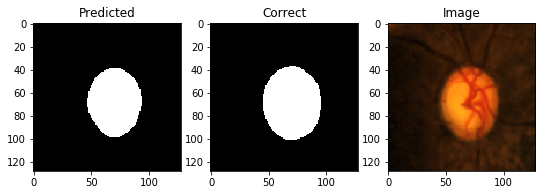

IOU: 0.8584457039833069
Dice: 0.9238318754000426
image #1


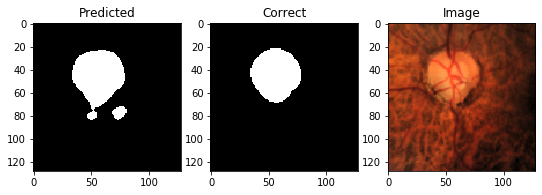

IOU: 0.828774631023407
Dice: 0.9063715225845049
image #2


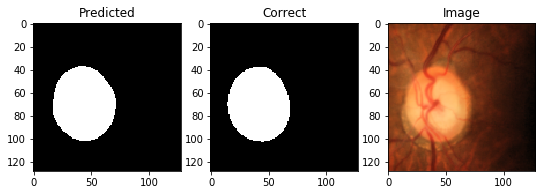

IOU: 0.923749566078186
Dice: 0.9603636363636363
image #3


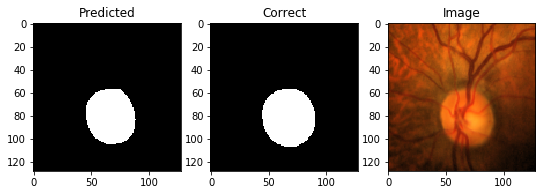

IOU: 0.8888888955116272
Dice: 0.9411764705882353
image #4


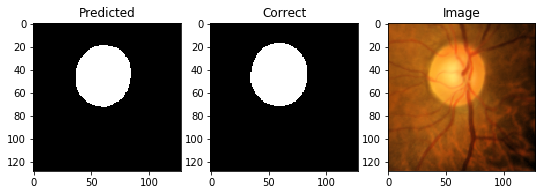

IOU: 0.9272559881210327
Dice: 0.9622551361681796
image #5


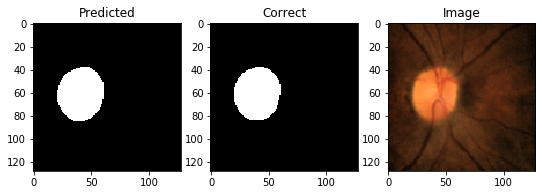

IOU: 0.9669093489646912
Dice: 0.9831763122476447
image #6


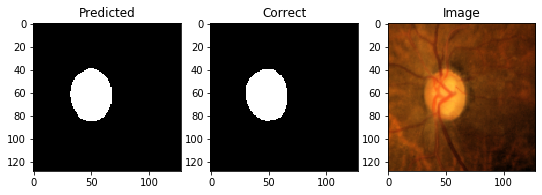

IOU: 0.9249070882797241
Dice: 0.9609887987640016
image #7


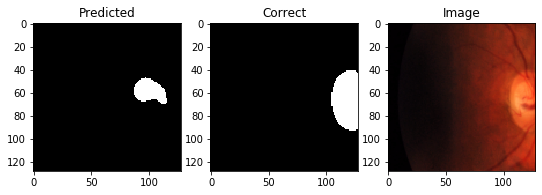

IOU: 0.10037735849618912
Dice: 0.18244170096021947
image #8


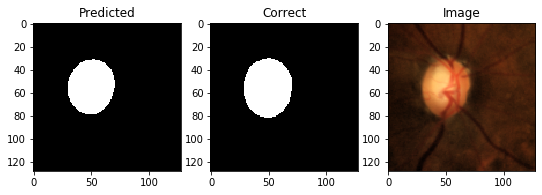

IOU: 0.8879813551902771
Dice: 0.9406674907292955
image #9


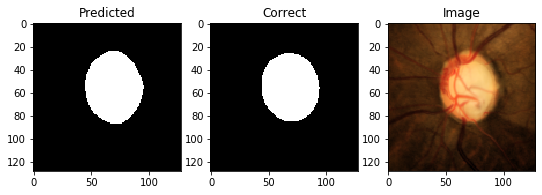

IOU: 0.9480147361755371
Dice: 0.9733137213700357
image #10


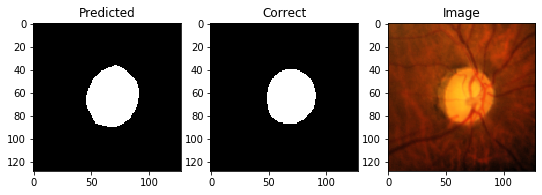

IOU: 0.8623656034469604
Dice: 0.9260969976905312
image #11


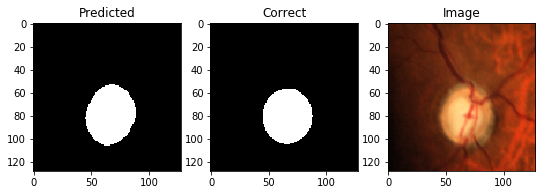

IOU: 0.8987485766410828
Dice: 0.9466746554823248
image #12


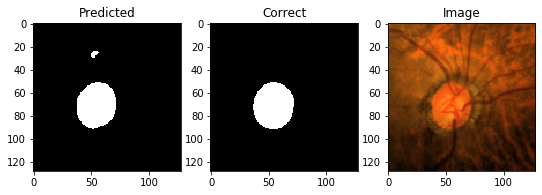

IOU: 0.9133390188217163
Dice: 0.9547069271758437
image #13


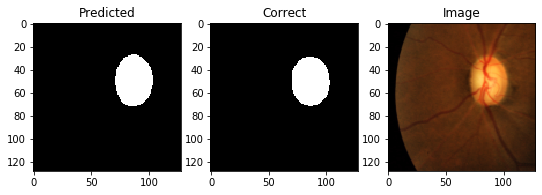

IOU: 0.9413265585899353
Dice: 0.9697766097240473
image #14


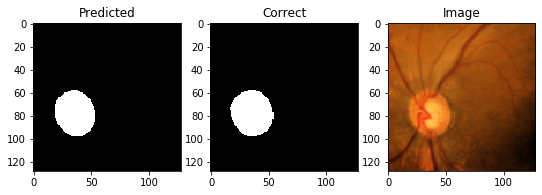

IOU: 0.9447323083877563
Dice: 0.9715808170515098
image #15


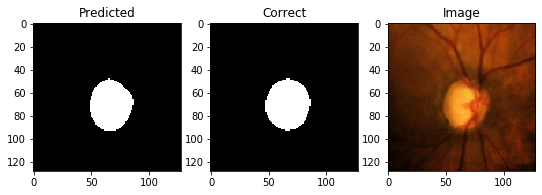

IOU: 0.9365781545639038
Dice: 0.9672505712109672
image #16


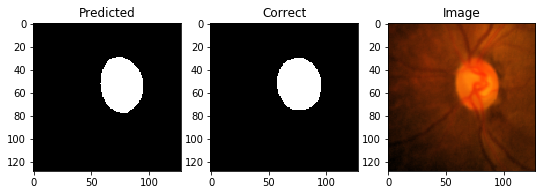

IOU: 0.9158040285110474
Dice: 0.9560518731988472
image #17


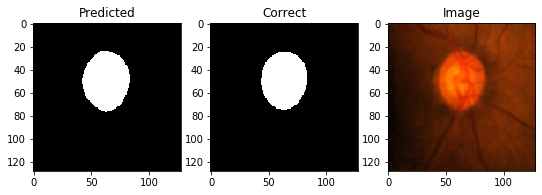

IOU: 0.927544891834259
Dice: 0.9624106865486176
image #18


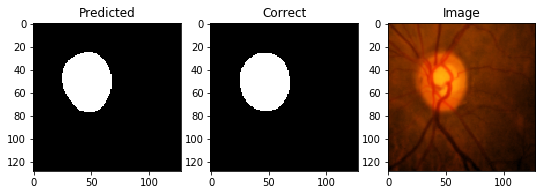

IOU: 0.9372570514678955
Dice: 0.9676124964173115
image #19


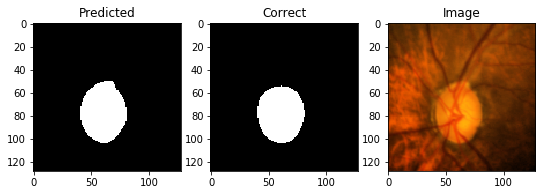

IOU: 0.9170616269111633
Dice: 0.9567367119901112
image #20


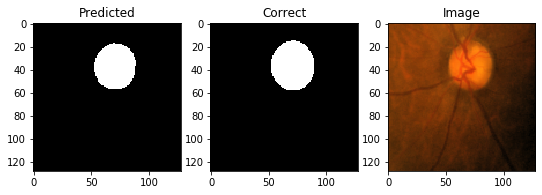

IOU: 0.8856695294380188
Dice: 0.9393687707641196
image #21


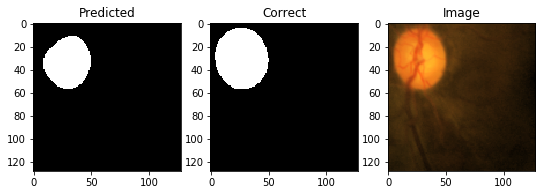

IOU: 0.7323726415634155
Dice: 0.845513963161022
image #22


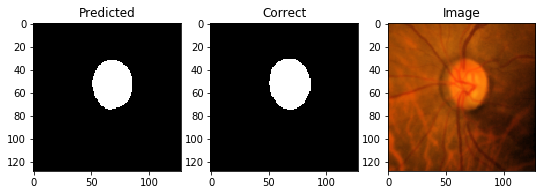

IOU: 0.9319999814033508
Dice: 0.9648033126293996
image #23


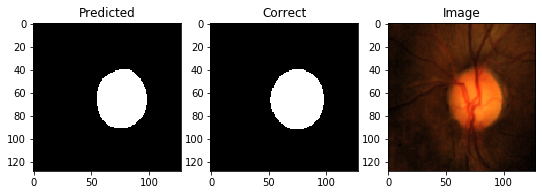

IOU: 0.9263707399368286
Dice: 0.9617782596909732
image #24


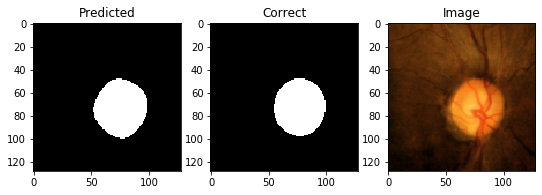

IOU: 0.8987206816673279
Dice: 0.9466591802358225
image #25


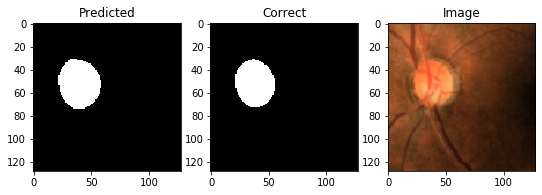

IOU: 0.8905872702598572
Dice: 0.9421276595744681
image #26


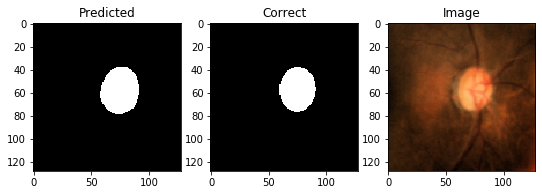

IOU: 0.8795955777168274
Dice: 0.9359413202933985
image #27


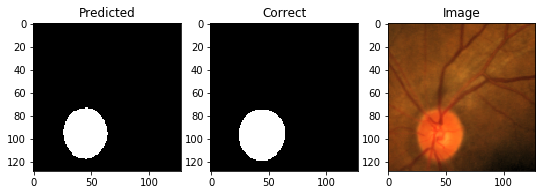

IOU: 0.8966480493545532
Dice: 0.9455081001472754
image #28


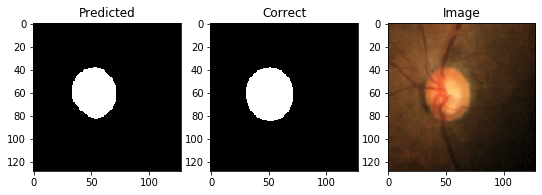

IOU: 0.8577101230621338
Dice: 0.9234057712860705
image #29


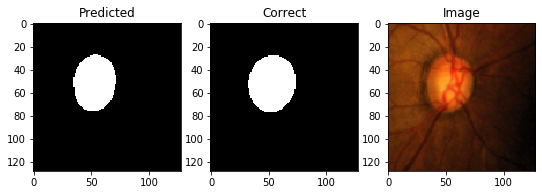

IOU: 0.8849281072616577
Dice: 0.9389515593895156
image #30


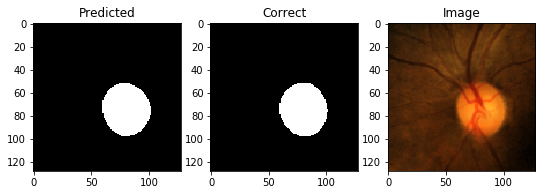

IOU: 0.9639580845832825
Dice: 0.9816483149816483
image #31


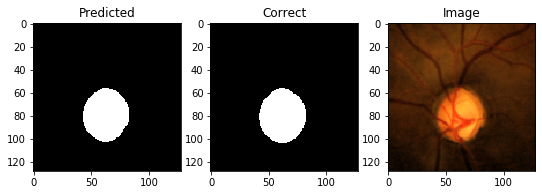

IOU: 0.9420386552810669
Dice: 0.9701543739279588
image #32


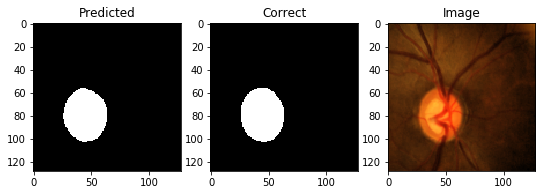

IOU: 0.9628571271896362
Dice: 0.9810771470160117
image #33


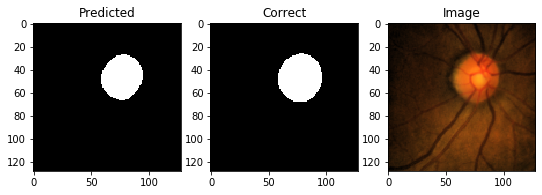

IOU: 0.8659217953681946
Dice: 0.9281437125748503
image #34


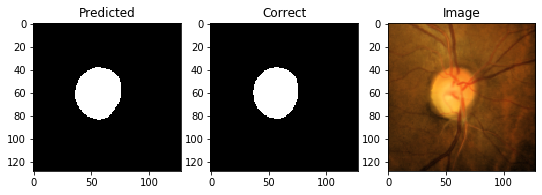

IOU: 0.9535865187644958
Dice: 0.9762419006479481
image #35


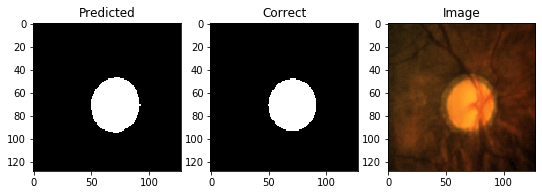

IOU: 0.9357914924621582
Dice: 0.9668308702791462
image #36


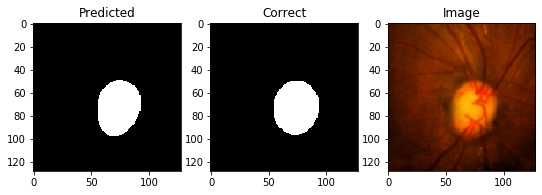

IOU: 0.9142480492591858
Dice: 0.9552033080634046
image #37


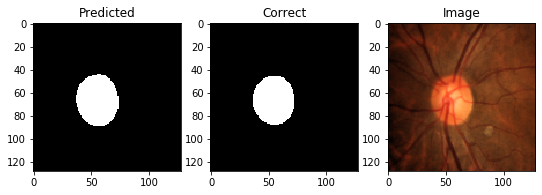

IOU: 0.9251908659934998
Dice: 0.9611419508326725
image #38


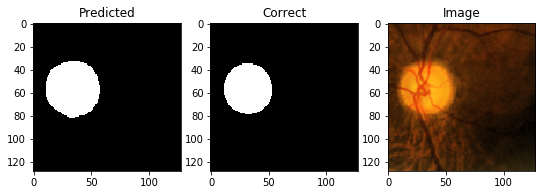

IOU: 0.8028634190559387
Dice: 0.8906536346976176
image #39


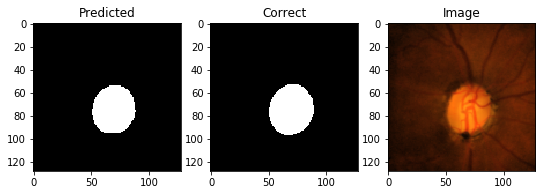

IOU: 0.9245141744613647
Dice: 0.9607766990291262
image #40


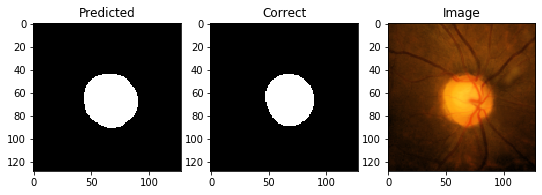

IOU: 0.8537005186080933
Dice: 0.9210770659238626
image #41


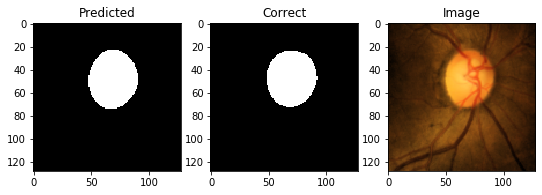

IOU: 0.9148336052894592
Dice: 0.9555228276877762
image #42


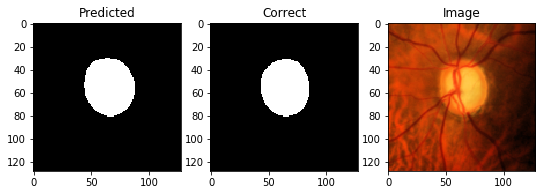

IOU: 0.921866238117218
Dice: 0.9593448376718339
image #43


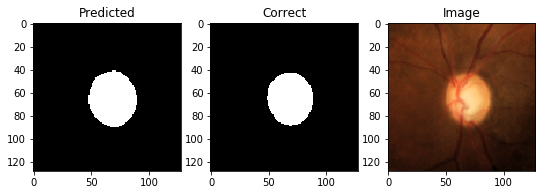

IOU: 0.9091486930847168
Dice: 0.9524126455906822
image #44


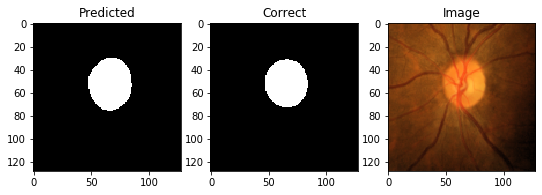

IOU: 0.889133632183075
Dice: 0.9413136416634279
image #45


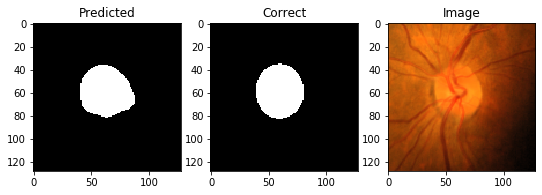

IOU: 0.8524971008300781
Dice: 0.9203761755485893
image #46


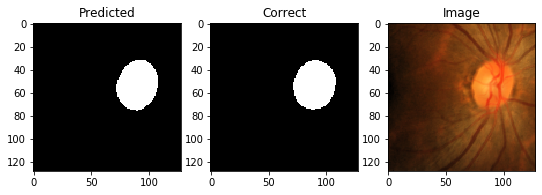

IOU: 0.9511218070983887
Dice: 0.9749486652977413
image #47


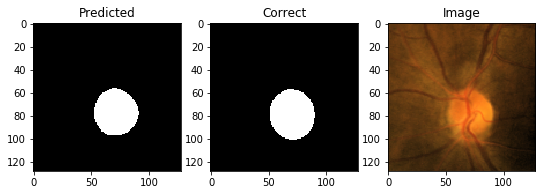

IOU: 0.8716265559196472
Dice: 0.93141075604053
image #48


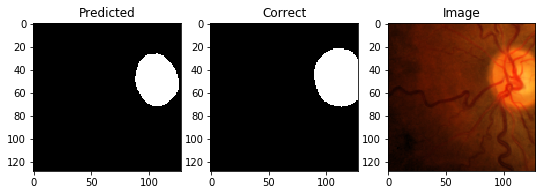

IOU: 0.7452267408370972
Dice: 0.854017094017094
image #49


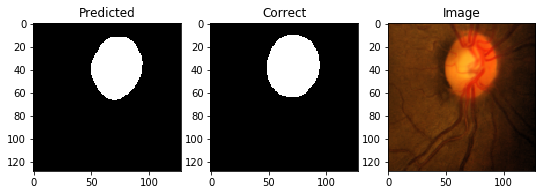

IOU: 0.9061876535415649
Dice: 0.9507853403141361


In [36]:
pred_iou, pred_dice = [], []
pred_disc = []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = img_train[img_no]
    batch_X = X_valid[i:i + 1]
    batch_z = Z_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    pred_disc.append(pred)
    corr = th_to_tf_encoding(batch_z)[0, ..., 0]
        
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = K.eval(mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]))
    cur_dice = K.eval(dice(pred[None, None, ...], corr[None, None, ...]))
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

In [37]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.88481957
0.9318124774128806


In [38]:
def ellipseFitting(img):
    contours, hierarchy = cv2.findContours(img.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    ellipse = np.zeros(img.shape)
    diametro = []
    for ind, cont in enumerate(contours):
        (x,y),(MA,ma),angle = cv2.fitEllipse(cont)
        diametro.append((MA, ma))
        cv2.ellipse(ellipse,(int(x),int(y)),(int(MA/2), int(ma/2)),angle,0,360,(255,255,255),0)
    return ellipse, diametro

In [39]:
import cv2
cdrs = []
for i, img_no in enumerate(test_idx):
    cup = pred_cup[i]
    disc = pred_disc[i]
        
    c = cv2.Canny(cup.astype(np.uint8), 1,1)
    d = cv2.Canny(disc.astype(np.uint8), 1,1)
    
    el_c, diam_c = ellipseFitting(c)
    el_d, diam_d = ellipseFitting(d)
        
    if len(diam_d) > 0 and len(diam_c) > 0:
        cdr = diam_c[0][1]/diam_d[0][1]
        cdrs.append(cdr)
        print('image #{} - cdr = {}'.format(img_no, cdr))


image #0 - cdr = 0.7959553770044641
image #1 - cdr = 2.5943181844706773
image #2 - cdr = 0.7715123244327965
image #3 - cdr = 0.7152091702221255
image #4 - cdr = 0.7497682447155499
image #5 - cdr = 0.7275174564353213
image #6 - cdr = 0.8467512558832814
image #7 - cdr = 0.4260348274409503
image #8 - cdr = 0.7921016718303348
image #9 - cdr = 0.874442048338831
image #10 - cdr = 0.8320030462049364
image #11 - cdr = 0.8892464849475913
image #12 - cdr = 0.6806354395095642
image #13 - cdr = 0.7861529670340084
image #14 - cdr = 0.7250295149614733
image #15 - cdr = 0.8096947150863838
image #16 - cdr = 0.6951579714638968
image #17 - cdr = 0.6714348657741803
image #18 - cdr = 0.7042569022099471
image #19 - cdr = 0.7697079115555777
image #20 - cdr = 0.7154596743923402
image #21 - cdr = 0.8523058303931974
image #22 - cdr = 0.7416844636420372
image #23 - cdr = 0.726632927331785
image #24 - cdr = 0.8281362809368412
image #25 - cdr = 0.6668022996570586
image #26 - cdr = 0.7939083118706878
image #27 - c